In [43]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [44]:
path = '/content/drive/MyDrive/Datasets'

In [45]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

In [46]:
tf.__version__

'2.6.0'

In [47]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [48]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [49]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [50]:
len(dataset)

68

In [51]:
2152/32

67.25

In [52]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 0 0 0 1 0 0 1 0 1 0 2 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1]


32 images, 256 by 256 size and RGB

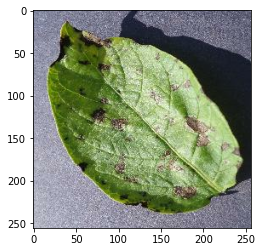

In [53]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))

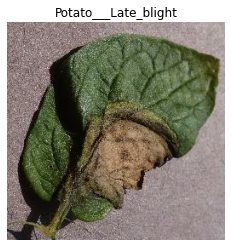

In [54]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[1]])
    plt.axis('off')

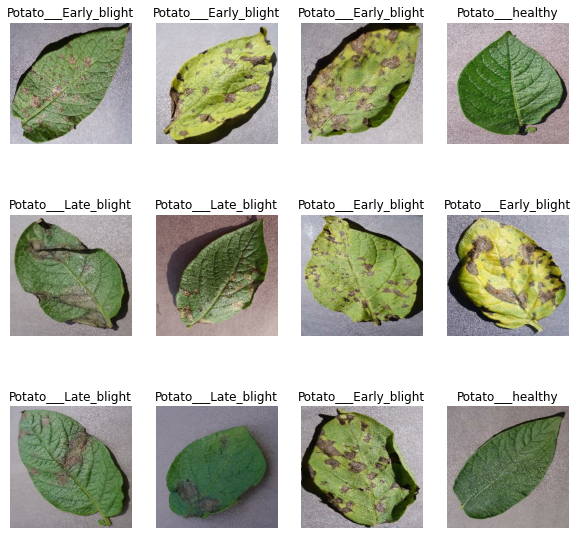

In [55]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [56]:
train_size =0.8

In [57]:
len(dataset)*train_size

54.400000000000006

In [58]:
train_ds = dataset.take(54)
len(train_ds)

54

In [59]:
test_ds = dataset.skip(len(train_ds))
len(test_ds)

14

In [60]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [61]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [62]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [63]:
def ds_dividing(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [64]:
train_ds, val_ds, test_ds = ds_dividing(dataset)

In [65]:
len(train_ds)

54

In [66]:
len(val_ds)

6

In [67]:
len(test_ds)

8

<B> Optimizing Train, Validation and Test </B>

In [68]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Image RGB cells into between 0 & 1

In [69]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    ])

In [70]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [71]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [72]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_4 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 60, 60, 64)         

In [73]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [74]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
    )

Epoch 1/30
54/54 [==============================] - 17s 211ms/step - loss: 0.9117 - accuracy: 0.4936 - val_loss: 0.8844 - val_accuracy: 0.5469
Epoch 2/30
54/54 [==============================] - 7s 123ms/step - loss: 0.6745 - accuracy: 0.6829 - val_loss: 0.5836 - val_accuracy: 0.7865
Epoch 3/30
54/54 [==============================] - 7s 121ms/step - loss: 0.5241 - accuracy: 0.7708 - val_loss: 0.3823 - val_accuracy: 0.8438
Epoch 4/30
54/54 [==============================] - 7s 122ms/step - loss: 0.3919 - accuracy: 0.8478 - val_loss: 0.3436 - val_accuracy: 0.8542
Epoch 5/30
54/54 [==============================] - 7s 121ms/step - loss: 0.3390 - accuracy: 0.8686 - val_loss: 0.2607 - val_accuracy: 0.8958
Epoch 6/30
54/54 [==============================] - 7s 123ms/step - loss: 0.2477 - accuracy: 0.9057 - val_loss: 0.2756 - val_accuracy: 0.8750
Epoch 7/30
54/54 [==============================] - 7s 122ms/step - loss: 0.1828 - accuracy: 0.9294 - val_loss: 0.2227 - val_accuracy: 0.8958
Epoch

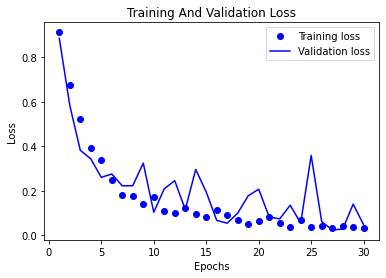

In [75]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training And Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

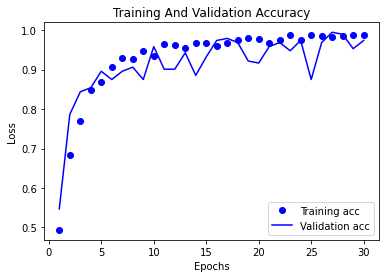

In [76]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training And Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [77]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 49ms/step - loss: 0.0100 - accuracy: 0.9961


In [78]:
scores

[0.009976077824831009, 0.99609375]

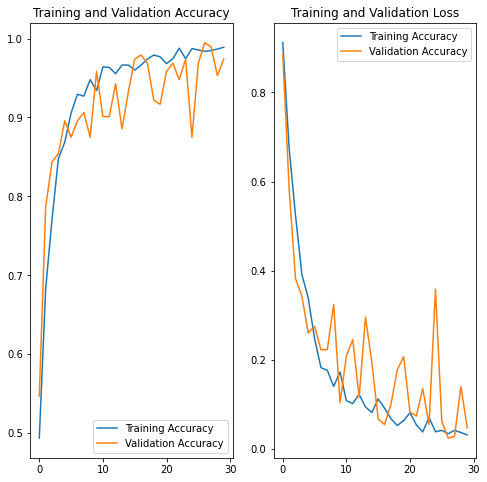

In [79]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Accuracy')
plt.plot(range(EPOCHS), val_loss, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First Image to Predict
First Image's actual label:  Potato___Late_blight


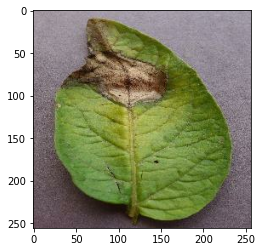

In [80]:
for image_batch, label_batch in dataset.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = label_batch[0]

  print('First Image to Predict')
  plt.imshow(first_image)
  print('First Image\'s actual label: ', class_names[first_label])

First Image to Predict
First Image's actual label:  Potato___Late_blight
Predicted label:  Potato___Late_blight


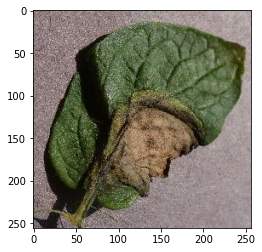

In [81]:
import numpy as np


for image_batch, label_batch in dataset.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = label_batch[0]

  print('First Image to Predict')
  plt.imshow(first_image)
  print('First Image\'s actual label: ', class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print('Predicted label: ', class_names[np.argmax(batch_prediction[0])])

**Testing** Prediction from the three 

In [82]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) #create a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence


Testing Actual name and predicting name similarites

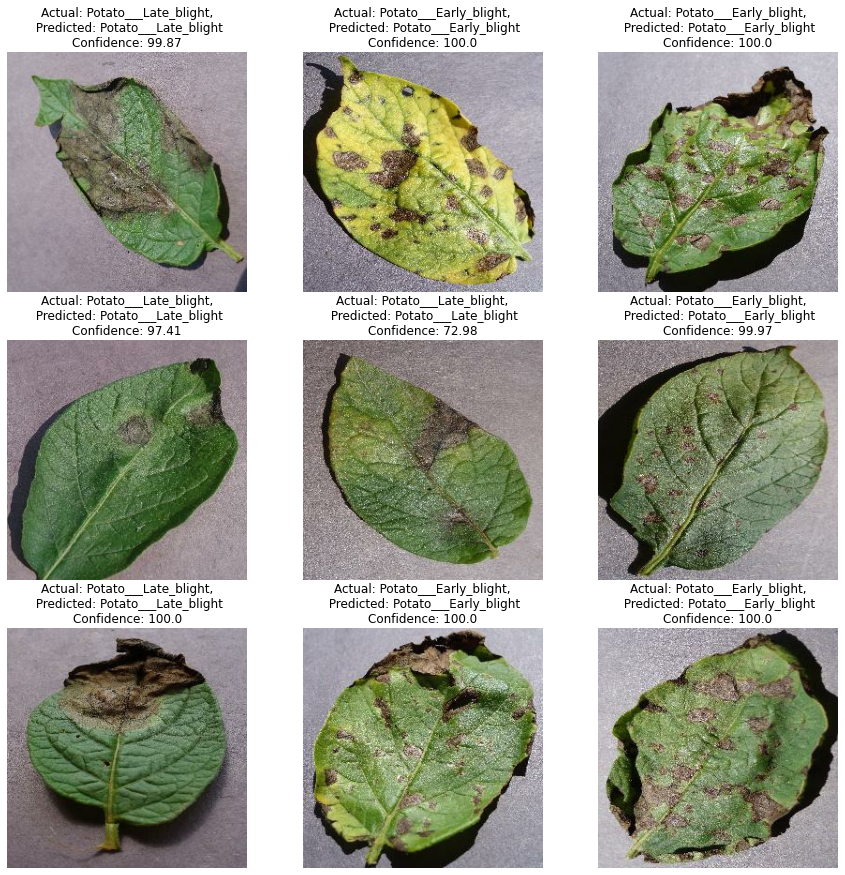

In [87]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predict_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predict_class}\nConfidence: {confidence}")
    plt.axis('off')

In [88]:
model_version = 'PotatoDiseaseModel_CNN'
model.save(f"/content/drive/MyDrive/models/{model_version}")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/PotatoDiseaseModel_CNN/assets
